1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

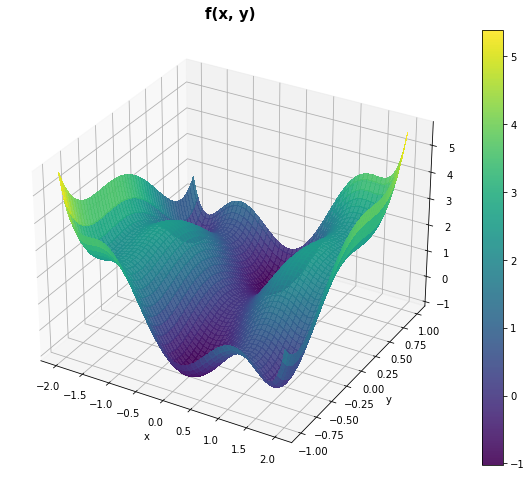

In [37]:
from scipy import optimize
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    return (4-2.1*x[0]**2+x[0]**4/3)*x[0]**2 + x[0]*x[1] + (4*x[1]**2-4)*x[1]**2

## PLOT
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
x, y = np.meshgrid(x, y)
z = f([x, y])

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.viridis,  linewidth=0, antialiased=False, alpha=0.9)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.8)

# Labels
ax.set_title('f(x, y)', fontweight = 'bold', fontsize = 15)
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.set_zlabel('f(x, y)')

plt.show()


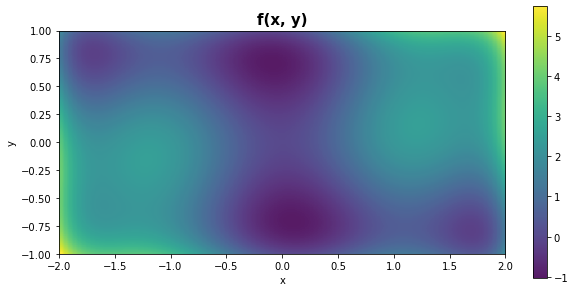

In [38]:
plt.figure(figsize=(10, 5))
plt.imshow(z, extent=(-2, 2, -1, 1), cmap=cm.viridis, alpha=0.9, origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x, y)', fontweight = 'bold', fontsize = 15)

plt.colorbar();

In [39]:
import pandas as pd
from IPython.display import display

starting_guesses = [[-1.5, 0], [1.5, 0], [0, -1], [0, 1]]
solutions = [optimize.minimize(f, x0 = i) for i in starting_guesses]

min_loc = {'initial guess': starting_guesses, 
           'x':[solution['x'][0] for solution in solutions], 
           'y':[solution['x'][1] for solution in solutions], 
           'f':[solution['fun'] for solution in solutions]}

minima = pd.DataFrame(min_loc)
print('Local minima:')
display(minima)

print('Global minima:')
display(minima.iloc[2:, :])

# TODO: minima with initial guess (0,0)


Local minima:


,initial guess,x,y,f
0,"[-1.5, 0]",-1.703607,0.796084,-0.215464
1,"[1.5, 0]",1.703607,-0.796084,-0.215464
2,"[0, -1]",0.089842,-0.712656,-1.031628
3,"[0, 1]",-0.089842,0.712656,-1.031628


Global minima:


,initial guess,x,y,f
2,"[0, -1]",0.089842,-0.712656,-1.031628
3,"[0, 1]",-0.089842,0.712656,-1.031628


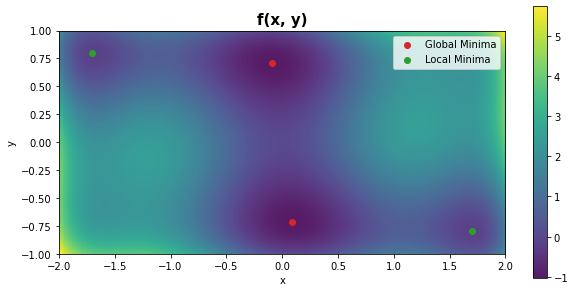

In [40]:
plt.figure(figsize=(10, 5))
plt.imshow(z, extent=(-2, 2, -1, 1), cmap=cm.viridis, alpha=0.9, origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x, y)', fontweight = 'bold', fontsize = 15)
plt.colorbar();

plt.scatter(minima['x'][2:], minima['y'][2:], label = 'Global Minima', color='C3')
plt.scatter(minima['x'][:2], minima['y'][:2], label = 'Local Minima', color='C2')
plt.legend();



In [41]:
solution_zero = optimize.minimize(f, [0, 0], method = 'CG')
print(solution_zero)

# todo: commentare i risultati usando diversi methods e provare a usare basinhooping

     fun: 0.0
     jac: array([ 5.96046448e-08, -5.96046448e-08])
 message: 'Optimization terminated successfully.'
    nfev: 3
     nit: 0
    njev: 1
  status: 0
 success: True
       x: array([0., 0.])


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

In [42]:
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize='15')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [43]:
# Data
months = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
Tmax = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
Tmin = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

dataset = pd.DataFrame({'Month': months, 'T max': Tmax, 'T min': Tmin})
print('Dataset of temperatures:')
display(dataset)

# Suitable functions
import math as m
def f_sinq(x, A, T, hshift, vshift):
    return A*np.sin(m.pi/T*x+hshift)**2 + vshift

def f_gauss(x, A, mu, std, vshift):
    return A*np.exp(-(x-mu)**2/(2*std**2))+vshift

# Fitting
## sinq
popt_M_sinq, pcov_M_sinq = optimize.curve_fit(f_sinq, np.arange(12), Tmax, p0=[10, 12, 0, 20])
popt_m_sinq, pcov_m_sinq = optimize.curve_fit(f_sinq, np.arange(12), Tmin, p0=[60, 12, 0, -60])

pstd_M_sinq = [np.sqrt(pcov_M_sinq[i,i]) for i in np.arange(4)]
pstd_m_sinq = [np.sqrt(pcov_m_sinq[i,i]) for i in np.arange(4)]

params = [[i, j] for i, j in zip(popt_M_sinq, popt_m_sinq)]
params_errors = [[i, j] for i, j in zip(pstd_M_sinq, pstd_m_sinq)]

params_sinq = pd.DataFrame({'A': params[0], 'Error (A)': params_errors[0],
           'T': params[1], 'Error (T)': params_errors[1], 
           'B': params[2], 'Error (B)': params_errors[2],
           'C': params[3], 'Error (C)': params_errors[3]}, index=['T max', 'T min'])

print('Sine squared fitting function parameters:')
display(params_sinq)

## gauss
popt_M_gauss, pcov_M_gauss = optimize.curve_fit(f_gauss, range(12), Tmax, p0=[30, 10, 5, 20])
popt_m_gauss, pcov_m_gauss = optimize.curve_fit(f_gauss, range(12), Tmin, p0=[40, 10, 5, -60])

pstd_M_gauss = [np.sqrt(pcov_M_gauss[i,i]) for i in range(4)]
pstd_m_gauss = [np.sqrt(pcov_m_gauss[i,i]) for i in range(4)]

params = [[i, j] for i, j in zip(popt_M_gauss, popt_m_gauss)]
params_errors = [[i, j] for i, j in zip(pstd_M_gauss, pstd_m_gauss)]

params_gauss = pd.DataFrame({'A': params[0], 'Error (A)': params_errors[0],
           'mu': params[1], 'Error (mu)': params_errors[1], 
           'std': params[2], 'Error (std)': params_errors[2], 
           'B': params[2], 'Error (B)': params_errors[3]}, index=['T max', 'T min'])

print('Gaussian function parameters:')
display(params_gauss)


Dataset of temperatures:


,Month,T max,T min
0,Jan,17,-62
1,Feb,19,-59
2,Mar,21,-56
3,April,28,-46
4,May,33,-32
5,June,38,-18
6,July,37,-9
7,Aug,37,-13
8,Sept,31,-25
9,Oct,23,-46


Sine squared fitting function parameters:


,A,Error (A),T,Error (T),B,Error (B),C,Error (C)
T max,21.163399,0.820157,10.608575,0.379421,-0.123930,0.063011,17.367936,0.581770
T min,50.299240,2.629124,10.448972,0.400308,-0.273153,0.071525,-61.862186,1.663816


Gaussian function parameters:


,A,Error (A),mu,Error (mu),std,Error (std),B,Error (B)
T max,23.092087,1.152655,5.735816,0.079468,2.294436,0.165960,2.294436,1.176540
T min,52.649290,1.403334,6.164526,0.047207,1.975900,0.075981,1.975900,1.188808


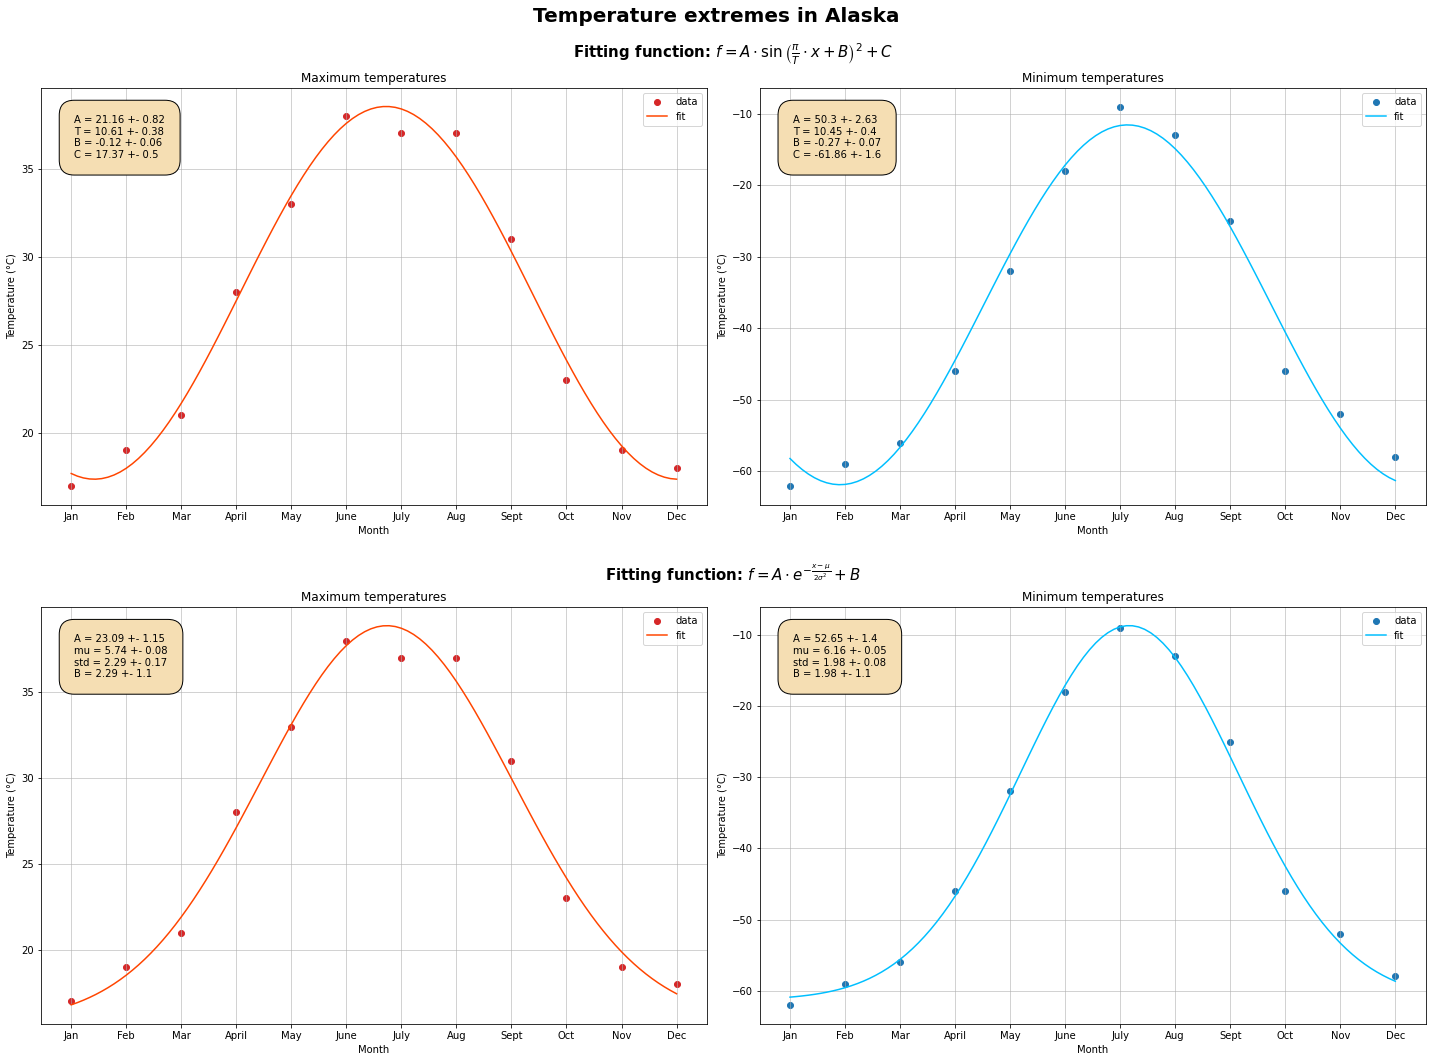

In [44]:
# Plot 
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

fig.suptitle('Temperature extremes in Alaska', fontweight='bold', fontsize='20' )
grid = plt.GridSpec(2, 2)

## Data
for i in range(2):
    ax[i, 0].scatter(months, Tmax, color='C3', label='data')
    ax[i, 0].set_xlabel('Month')
    ax[i, 0].set_ylabel('Temperature (°C)')
    ax[i, 0].set_title('Maximum temperatures')

    ax[i, 1].scatter(months, Tmin, color='C0', label='data')
    ax[i, 1].set_xlabel('Month')
    ax[i, 1].set_ylabel('Temperature (°C)')
    ax[i, 1].set_title('Minimum temperatures')


## Fitting curves
x_temp = np.linspace(0, 11, 100)

### sinq
ax[0, 0].plot(x_temp, f_sinq(x_temp, *popt_M_sinq), color='orangered', label='fit')
ax[0, 1].plot(x_temp, f_sinq(x_temp, *popt_m_sinq), color='deepskyblue', label='fit')
ax[0, 0].legend()
ax[0, 1].legend()

create_subtitle(fig, grid[0, ::], r'Fitting function: $f = A\cdot\sin\left(\frac{\pi}{T}\cdot x + B\right)^2+C$')

### gauss
ax[1, 0].plot(x_temp, f_gauss(x_temp, *popt_M_gauss), color='orangered', label='fit')
ax[1, 1].plot(x_temp, f_gauss(x_temp, *popt_m_gauss), color='deepskyblue', label='fit')
ax[1, 0].legend()
ax[1, 1].legend()

create_subtitle(fig, grid[1, ::], r'Fitting function: $f = A\cdot e^{-\frac{x-\mu}{2\sigma^2}}+B$')

## Results
text_M_sinq = ''
for i in range(0, 8, 2):
    text_M_sinq += params_sinq.columns[i] + ' = ' + str(round(params_sinq.iloc[0, i], 2)) + ' +- ' + str(round(params_sinq.iloc[0, i+1],2))+'\n'
text_m_sinq = ''
for i in range(0, 8, 2):
    text_m_sinq += params_sinq.columns[i] + ' = ' + str(round(params_sinq.iloc[1, i], 2)) + ' +- ' + str(round(params_sinq.iloc[1, i+1],2))+'\n'
text_M_gauss = ''
for i in range(0, 8, 2):
    text_M_gauss += params_gauss.columns[i] + ' = ' + str(round(params_gauss.iloc[0, i], 2)) + ' +- ' + str(round(params_gauss.iloc[0, i+1],2))+'\n'
text_m_gauss = ''
for i in range(0, 8, 2):
    text_m_gauss += params_gauss.columns[i] + ' = ' + str(round(params_gauss.iloc[1, i], 2)) + ' +- ' + str(round(params_gauss.iloc[1, i+1],2))+'\n'
    
text_plot = [[text_M_sinq[:-2], text_m_sinq[:-2]], [text_M_gauss[:-2], text_m_gauss[:-2]]]

for i in range(2):
    for j in range(2):
        ax[i, j].text(0.05, 0.88, 
            s= text_plot[i][j],
            transform=ax[i,j].transAxes,
            bbox={'facecolor': 'wheat', 'alpha': 1, 'pad': 1.5, 'boxstyle':'round'},
            verticalalignment='center', 
            );
        
        ax[i, j].grid(alpha=0.7)

## Settings        
fig.tight_layout()  
fig.set_facecolor('w')

# TODO: ultime domande + spiegazione periodicità e risultati

Let us extend these results outside the given time interval:

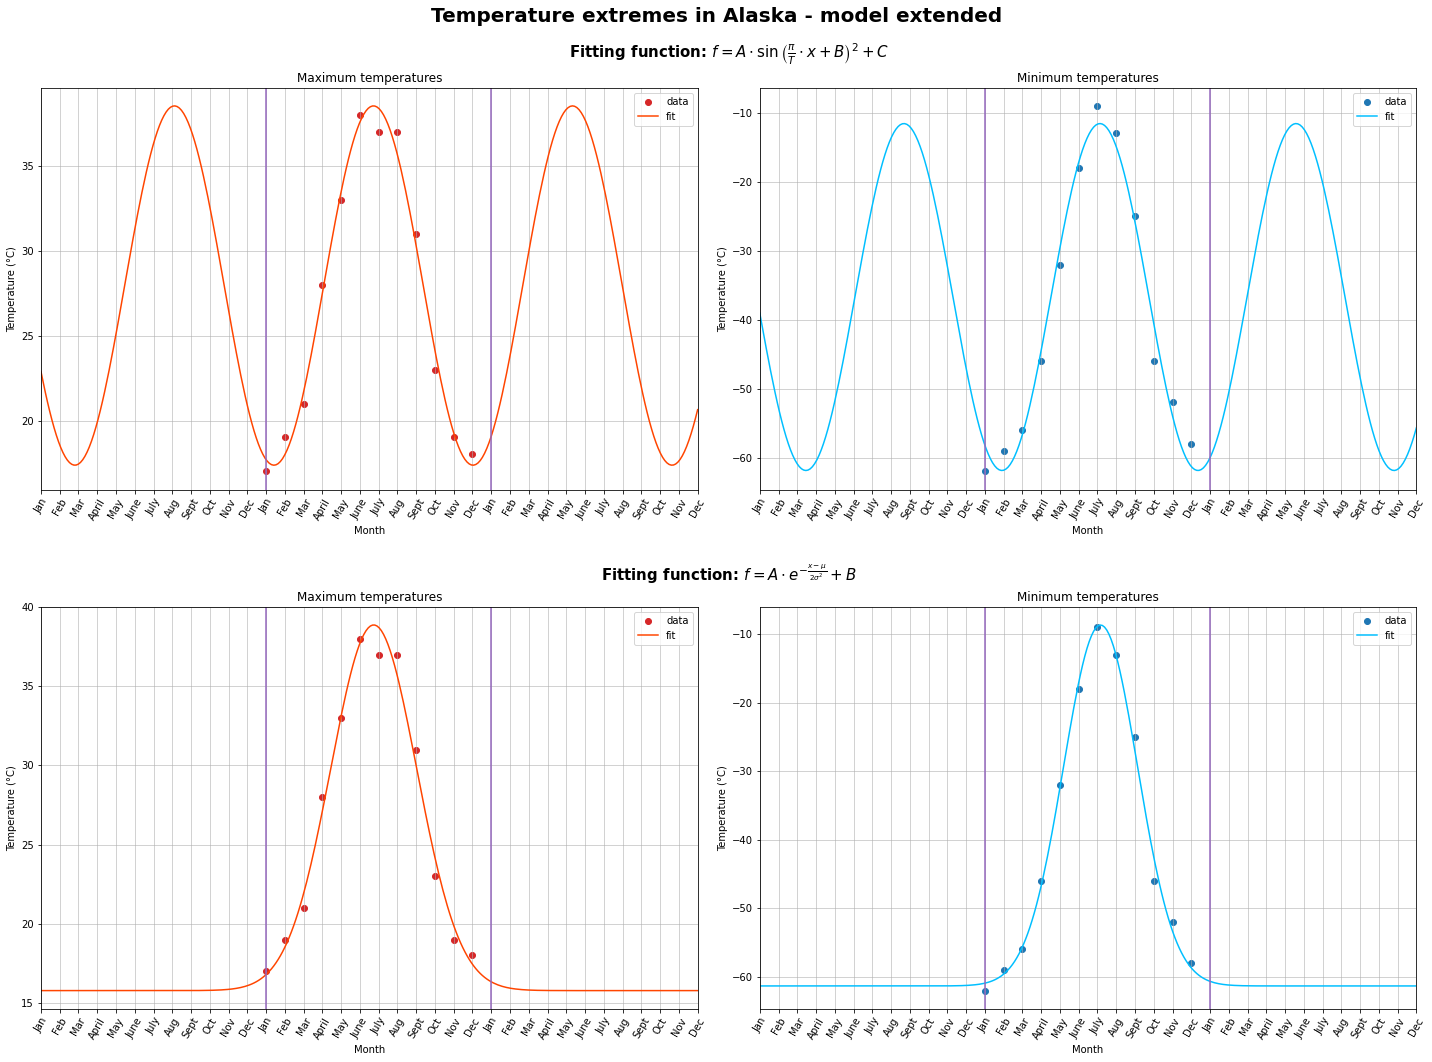

In [45]:
# New Plot 
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

fig.suptitle('Temperature extremes in Alaska - model extended', fontweight='bold', fontsize='20' )
grid = plt.GridSpec(2, 2)

## Data
for i in range(2):
    ax[i, 0].scatter(months, Tmax, color='C3', label='data')
    ax[i, 0].set_xlabel('Month')
    ax[i, 0].set_ylabel('Temperature (°C)')
    ax[i, 0].set_title('Maximum temperatures')

    ax[i, 1].scatter(months, Tmin, color='C0', label='data')
    ax[i, 1].set_xlabel('Month')
    ax[i, 1].set_ylabel('Temperature (°C)')
    ax[i, 1].set_title('Minimum temperatures')


## Fitting curves
x_temp = np.linspace(-12, 23, 300)

### sinq
ax[0, 0].plot(x_temp, f_sinq(x_temp, *popt_M_sinq), color='orangered', label='fit')
ax[0, 1].plot(x_temp, f_sinq(x_temp, *popt_m_sinq), color='deepskyblue', label='fit')
ax[0, 0].legend()
ax[0, 1].legend()

create_subtitle(fig, grid[0, ::], r'Fitting function: $f = A\cdot\sin\left(\frac{\pi}{T}\cdot x+B\right)^2+C$')

### gauss
ax[1, 0].plot(x_temp, f_gauss(x_temp, *popt_M_gauss), color='orangered', label='fit')
ax[1, 1].plot(x_temp, f_gauss(x_temp, *popt_m_gauss), color='deepskyblue', label='fit')
ax[1, 0].legend()
ax[1, 1].legend()

create_subtitle(fig, grid[1, ::], r'Fitting function: $f = A\cdot e^{-\frac{x-\mu}{2\sigma^2}}+B$')

## Results
for i in range(2):
    for j in range(2):
        # ax[i, j].text(0.05, 0.88, 
        #     s= text_plot[i][j],
        #     transform=ax[i,j].transAxes,
        #     bbox={'facecolor': 'wheat', 'alpha': 1, 'pad': 1.5, 'boxstyle':'round'},
        #     verticalalignment='center', 
        #     );
        
        ax[i, j].grid(alpha=0.7)
        ax[i, j].xaxis.set_tick_params(rotation=60)
        ax[i, j].set_xticks(ticks=range(-12, 24))
        ax[i, j].set_xticklabels(months*3)
        ax[i, j].set_xlim(-12, 23)
        ax[i, j].axvline(0, color='C4')
        ax[i, j].axvline(12, color='C4')

## Settings        
fig.tight_layout()  
fig.set_facecolor('w')

In [58]:
# Time offset for min and max temperatures
## sinq
sinq_offset = abs(params_sinq['T'][0]*(0.5-params_sinq['B'][0]/m.pi) - params_sinq['T'][1]*(0.5-params_sinq['B'][1]/m.pi))
comp_sinq = sinq_offset/(params_sinq['Error (T)']*params_sinq['Error (B)']).sum()
print(comp_sinq)

## gauss
gauss_offset = abs(params_gauss['mu'][0]-params_gauss['mu'][1])
comp_gauss = gauss_offset/params_gauss['Error (mu)'].sum()
print(comp_gauss)

7.80778651448121
3.3843404053100374


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

0        1.100000
1       -1.950000
2       -7.200000
3       -4.150000
4       -6.590000
           ...   
11126   -0.760000
11127    0.380000
11128    0.083333
11129    0.166667
11130    0.083333
Name: residuals, Length: 11131, dtype: float64

(-5.0, 5.0)

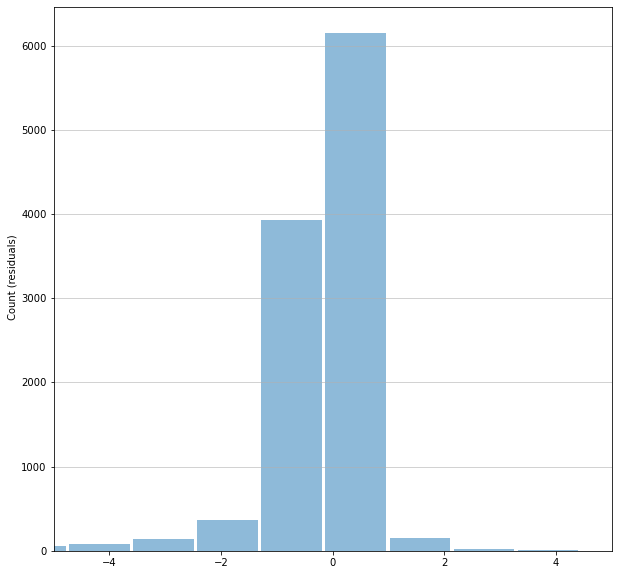

In [47]:
import math as m

# TODO: rivedo esercizio 3 week 06 alla luce di questa spiegazione
filename = '/Users/Nicola/data/residuals_261.npy'
dataframe = pd.DataFrame(np.load(filename, allow_pickle=True).item())
display(dataframe['residuals'])

fig, ax = plt.subplots(figsize=(10, 10))
n, bins, _= ax.hist(dataframe['residuals'], bins=150, alpha=0.5, rwidth=0.95, color='C0')

ax.set_ylabel(' Count (residuals)')
ax.grid(axis='y', alpha=0.7)
ax.set_xlim(left = -5, right=5) 

# TODO: rifarlo con il file giusto ...

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(t)$, which has 1 more parameter than $f(t)$.
$$g(t) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(t)$ and $g(t)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [48]:
def f(t, a, b, c):
    return a*np.cos(2*m.pi*t+b)+c

def g(t, a, b, c, d):
    return a*np.cos(2*m.pi*b*t+c)+d

